In [ ]:
# Example: UNet 2D for image segmentation with 2 labels
# The images are 128 pixels x 128 pixels 3 channels RGB 
# In this exercise UNet is trained to segment background and curve data from images
# I acknowledge "Sreenivas Bhattiprolu" ( https://github.com/bnsreenu/python_for_microscopists),
# the based code for UNet has been taken from his git 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import os
import math
import tensorflow as tf
import os
import random
import numpy as np
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

In [ ]:
location= '/content/drive/MyDrive/AI/OriginalImagesPieces'
# Location for Original images
files = []
no = []
for file in os.listdir(location):
    if ("ipynb") in file: 
        no.append(str(file))
    else: 
        files.append(str(file))
print(files[0:10])

In [ ]:
locationMask= '/content/drive/MyDrive/AI/MMaskPieces'
# Location for Mask images
# The mask files are here printed just for checking
filesMask = []
no = []
for file in os.listdir(locationMask):
    if ("ipynb") in file: 
        no.append(str(file))
    else: 
        filesMask.append(str(file))
print(filesMask[0:10])

['Doc10033_M_2-0_1080-5018_128-128.png', 'Doc10033_M_2-1_1080-5018_128-128.png', 'Doc10033_M_2-2_1080-5018_128-128.png', 'Doc10033_M_2-3_1080-5018_128-128.png', 'Doc10033_M_2-4_1080-5018_128-128.png', 'Doc10033_M_2-5_1080-5018_128-128.png', 'Doc10033_M_2-6_1080-5018_128-128.png', 'Doc10033_M_2-7_1080-5018_128-128.png', 'Doc10033_M_2-8_1080-5018_128-128.png', 'Doc10033_M_2-9_1080-5018_128-128.png']


In [ ]:
seed = 42
np.random.seed = seed
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
numeImag= 8564
X = np.zeros((numeImag, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y = np.zeros((numeImag, IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

In [ ]:
# Real Images are named with _O_ and mask images has _M_ instead
n=0
locationMask= '/content/drive/MyDrive/AI/MMaskPieces'
for dataLink in files:
    data= location+'/'+dataLink
    dataLinkMask= dataLink.replace("_O_","_M_").replace("jpg","png")
    dataMask=locationMask+'/'+dataLinkMask
    img = imread(data)[:,:,:IMG_CHANNELS]  
    X[n] = img  #Fill empty X_train with values from img
    imgMask = imread(dataMask)[:,:,:1]  
    Y[n] = imgMask
    n= n+1
    if n== numeImag:
        break

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=20)

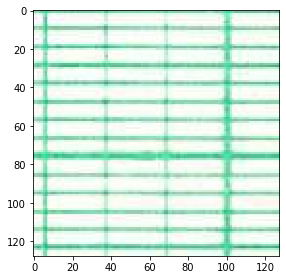

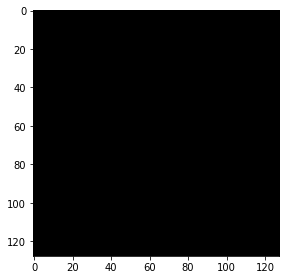

In [ ]:
image_x = random.randint(0, len(X_train))
imshow(X_train[image_x])
plt.show()
imshow(np.squeeze(Y_train[image_x]))
plt.show()

In [ ]:

#Build the model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 128, 128, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  448         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

In [ ]:
#Modelcheckpoint
checkpointer = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/AI_Bandas/model_for_nucleiL.h5', verbose=1, save_best_only=True)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='/content/drive/MyDrive/AI_Bandas/logs')]

results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=3, callbacks=callbacks)


Epoch 1/3
323/323 [==============================] - 949s 3s/step - loss: 0.0249 - accuracy: 0.9921 - val_loss: 0.0124 - val_accuracy: 0.9964
Epoch 2/3
323/323 [==============================] - 937s 3s/step - loss: 0.0068 - accuracy: 0.9976 - val_loss: 0.0048 - val_accuracy: 0.9983
Epoch 3/3
323/323 [==============================] - 938s 3s/step - loss: 0.0060 - accuracy: 0.9978 - val_loss: 0.0044 - val_accuracy: 0.9985


In [ ]:
idx = random.randint(0, len(X_train))
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)
 
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()


In [ ]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, 20)
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

In [ ]:
# Saving Model
from tensorflow.keras.models import load_model
model.save('/content/drive/MyDrive/AI/longEightkModelKerasSaver.h5')  # creates a HDF5 file 'my_model.h5'